In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!pip install timm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 20.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 27.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 48.7 MB/s eta 0:00:00


In [4]:
%matplotlib inline
import torchvision
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader,Dataset
import matplotlib.pyplot as plt
import torchvision.utils
import numpy as np
import random
from PIL import Image
import torch
from torch.autograd import Variable
import PIL.ImageOps
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
from tqdm import tqdm
import os
import cv2
import pandas as pd
import timm

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

train_data_dir = '/content/drive/MyDrive/Assignment_Pixxel/imagenette2-320/train'
val_data_dir = '/content/drive/MyDrive/Assignment_Pixxel/imagenette2-320/val'
save_dir = '/content/drive/MyDrive/Assignment_Pixxel'
train_csv_path = '/content/drive/MyDrive/Assignment_Pixxel/imagenette2-320/train_two_label.csv'
val_csv_path = '/content/drive/MyDrive/Assignment_Pixxel/imagenette2-320/val_two_label.csv'

BATCH_SIZE = 32
LR = 0.001
EPOCH = 30

cpu


In [6]:
def imshow(img,text=None,should_save=False):
    """
    Plots Images when passed as Tensors
    """

    npimg = img.numpy()
    plt.axis("off")
    if text:
        plt.text(75, 8, text, style='italic',fontweight='bold',
            bbox={'facecolor':'white', 'alpha':0.8, 'pad':10})
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


In [7]:
class SiameseNetworkDataset(Dataset):
        def __init__(self,csv_path, data_dir_path,transform=None):
            self.data_dir_path = data_dir_path
            self.transform = transform
            self.df = pd.read_csv(csv_path)

        def __len__(self):
            return len(self.df)

        def __getitem__(self,idx):
            img1_name, img2_name, label = self.df.iloc[idx]

            img1_path = os.path.join(self.data_dir_path,img1_name)
            img2_path = os.path.join(self.data_dir_path,img2_name)

            img1 = cv2.imread(img1_path)
            img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
            img1 = Image.fromarray(img1)

            img2 = cv2.imread(img2_path)
            img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)
            img2 = Image.fromarray(img2)

            if self.transform:
                img1 = self.transform(img1)
                img2 = self.transform(img2)
            return img1,img2, label

In [8]:
train_transform = transforms.Compose([transforms.ToTensor(),transforms.Resize((228,228))]) #converting the dimension from (height,weight,channel) to (channel,height,weight) convention of PyTorch


validate_transform = transforms.Compose([transforms.ToTensor(),transforms.Resize((228,228))]) #converting the dimension from (height,weight,channel) to (channel,height,weight) convention of PyTorch


In [9]:
trainset = SiameseNetworkDataset(csv_path = train_csv_path,
                                 data_dir_path = train_data_dir,
                                 transform = train_transform)
testset = SiameseNetworkDataset(csv_path = val_csv_path,
                                data_dir_path = val_data_dir,
                                transform = validate_transform)

1280


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


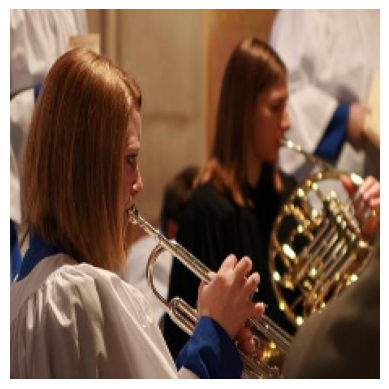

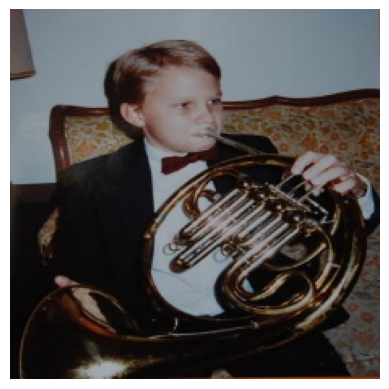

1


In [ ]:
print(len(trainset))
a,b,c = trainset[0]
imshow(a)
imshow(b)
print(c)

In [10]:
trainloader = DataLoader(trainset,batch_size= 32,shuffle=True)
print("No. of batches in trainloader:{}".format(len(trainloader)))
print("No. of Total examples:{}".format(len(trainloader.dataset)))

No. of batches in trainloader:40
No. of Total examples:1280


In [11]:
testloader = DataLoader(testset,batch_size= 32)
print("No. of batches in trainloader:{}".format(len(testloader)))
print("No. of Total examples:{}".format(len(testloader.dataset)))

No. of batches in trainloader:10
No. of Total examples:320


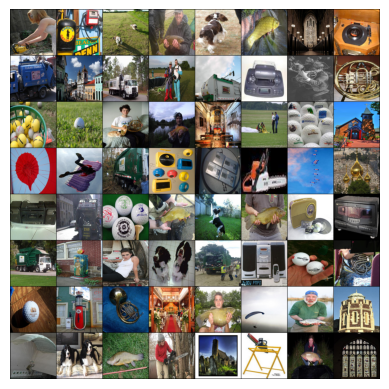

[0 0 0 1 1 1 0 1 1 0 1 0 1 1 0 1 1 0 1 0 0 1 0 1 1 0 0 0 0 1 0 1]


In [ ]:
"""
Visualization of a batch : images and pred value
first 4 rows are first images and the last 4 rows are corresponding second images
"""

example_batch = next(iter(trainloader))
concatenated = torch.cat((example_batch[0],example_batch[1]),0)
imshow(torchvision.utils.make_grid(concatenated))
print(example_batch[2].numpy())

## Model

In [13]:
class ClassificationNet(nn.Module):
    def __init__(self):
        super(ClassificationNet, self).__init__()
        self.efficientnet = timm.create_model('efficientnet_b0', pretrained = True)
        num_filters = self.efficientnet.classifier.in_features
        self.efficientnet.classifier = nn.Sequential(nn.Linear(num_filters,512),
                                                     nn.ReLU(),
                                                     nn.Linear(512,10))

        self.fc1 = nn.Linear(10, 1)

    def forward(self, x1, x2):
        output1 = self.efficientnet(x1)
        output2 = self.efficientnet(x2)

        diff_tensor = torch.abs(output1 - output2)
        scores = torch.sigmoid(self.fc1(diff_tensor))
        return scores


In [15]:
mymodel = ClassificationNet()

In [16]:
criterion = nn.BCELoss()
optimizer = optim.Adam(mymodel.parameters(),lr = LR )

In [ ]:
def binary_acc(y_pred,y_test):
    y_pred_tag = torch.round(y_pred)

    correct_results_sum = (y_pred_tag == y_test).sum().float()
    acc = correct_results_sum/y_test.shape[0]
    acc = torch.round(acc * 100)

    return acc

In [ ]:
class Trainer():

    def __init__(self,criterion = None,optimizer = None):

        self.criterion = criterion
        self.optimizer = optimizer

    def train(self, model, train_loader,epoch):

        model.to(device)
        epoch_loss = 0
        epoch_acc = 0

        for imgs1, imgs2, label in tqdm(train_loader):

            #take data to device
            imgs1 = imgs1.to(device)
            imgs2 = imgs2.to(device)
            label = label.to(device)

            # compute output
            output = model(imgs1,imgs2)
            loss = self.criterion(output, label.unsqueeze(1).float())
            acc = binary_acc(output, label.unsqueeze(1).float())

            # compute gradient and do SGD step
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()

            epoch_loss += loss.item()
            epoch_acc += acc.item()

        print(f'Epoch {epoch+0:03}: | Training Loss: {epoch_loss/len(train_loader):.5f} | Training Acc: {epoch_acc/len(train_loader):.3f}')
        return epoch_loss / len(trainloader)

    def validate(self, model, validationloader,epoch):

        model.to(device)
        valid_loss = 0
        valid_acc = 0

        with torch.no_grad():
            for imgs1, imgs2, label in tqdm(validationloader):

                #take data to device
                imgs1 = imgs1.to(device)
                imgs2 = imgs2.to(device)
                label = label.to(device)

                # compute output
                output = model(imgs1,imgs2)
                loss = self.criterion(output, label.unsqueeze(1).float())
                acc = binary_acc(output, label.unsqueeze(1).float())

                valid_loss += loss.item()
                valid_acc += acc.item()

            print(f'Epoch {epoch+0:03}: | Validation Loss: {valid_loss/len(validationloader):.5f} | Validation Acc: {valid_acc/len(validationloader):.3f}')
            return valid_loss / len(validationloader)

    def fit(self,model,trainloader,validationloader,epochs):

        valid_min_loss = np.Inf
        train_loss_epoch =[]
        test_loss_epoch = []
        for i in range(epochs):

            # switch to train mode
            model.train()
            avg_train_loss = self.train(model,trainloader,i) ###

            model.eval()  # this turns off the dropout lapyer and batch norm
            avg_valid_loss = self.validate(model,validationloader,i) ###

            #add loss of each epoch
            train_loss_epoch.append(avg_train_loss)
            test_loss_epoch.append(avg_valid_loss)

            if avg_valid_loss <= valid_min_loss :
                print("test_loss decreased {} --> {}".format(valid_min_loss,avg_valid_loss))
                torch.save(model.state_dict(),('/content/drive/MyDrive/Assignment_Pixxel/model_best.pt'))
                valid_min_loss = avg_valid_loss

        plt.plot(train_loss_epoch, label='training loss')
        plt.plot(test_loss_epoch, label='test loss')
        plt.title('Loss at the end of each epoch')
        plt.legend()
        plt.savefig('loss_plot.png')

  0%|          | 0/40 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
100%|██████████| 40/40 [09:48<00:00, 14.72s/it]


Epoch 000: | Training Loss: 0.66906 | Training Acc: 54.375


100%|██████████| 10/10 [02:57<00:00, 17.73s/it]


Epoch 000: | Validation Loss: 0.65595 | Validation Acc: 59.200
test_loss decreased inf --> 0.6559549987316131


100%|██████████| 40/40 [00:35<00:00,  1.14it/s]


Epoch 001: | Training Loss: 0.63972 | Training Acc: 62.675


100%|██████████| 10/10 [00:05<00:00,  1.71it/s]


Epoch 001: | Validation Loss: 0.65187 | Validation Acc: 61.600
test_loss decreased 0.6559549987316131 --> 0.6518712401390075


100%|██████████| 40/40 [00:34<00:00,  1.15it/s]


Epoch 002: | Training Loss: 0.58347 | Training Acc: 69.625


100%|██████████| 10/10 [00:06<00:00,  1.61it/s]


Epoch 002: | Validation Loss: 0.64936 | Validation Acc: 60.900
test_loss decreased 0.6518712401390075 --> 0.6493600755929947


100%|██████████| 40/40 [00:34<00:00,  1.16it/s]


Epoch 003: | Training Loss: 0.57590 | Training Acc: 69.175


100%|██████████| 10/10 [00:06<00:00,  1.46it/s]


Epoch 003: | Validation Loss: 0.60959 | Validation Acc: 65.700
test_loss decreased 0.6493600755929947 --> 0.6095901191234588


100%|██████████| 40/40 [00:34<00:00,  1.16it/s]


Epoch 004: | Training Loss: 0.51654 | Training Acc: 74.625


100%|██████████| 10/10 [00:06<00:00,  1.45it/s]


Epoch 004: | Validation Loss: 0.67006 | Validation Acc: 66.700


100%|██████████| 40/40 [00:35<00:00,  1.12it/s]


Epoch 005: | Training Loss: 0.52643 | Training Acc: 74.575


100%|██████████| 10/10 [00:06<00:00,  1.54it/s]


Epoch 005: | Validation Loss: 0.58505 | Validation Acc: 71.200
test_loss decreased 0.6095901191234588 --> 0.5850455701351166


100%|██████████| 40/40 [00:35<00:00,  1.14it/s]


Epoch 006: | Training Loss: 0.43940 | Training Acc: 79.000


100%|██████████| 10/10 [00:06<00:00,  1.63it/s]


Epoch 006: | Validation Loss: 0.57264 | Validation Acc: 74.400
test_loss decreased 0.5850455701351166 --> 0.5726428240537643


100%|██████████| 40/40 [00:35<00:00,  1.13it/s]


Epoch 007: | Training Loss: 0.37146 | Training Acc: 85.325


100%|██████████| 10/10 [00:05<00:00,  1.71it/s]


Epoch 007: | Validation Loss: 0.49636 | Validation Acc: 77.300
test_loss decreased 0.5726428240537643 --> 0.49635851085186006


100%|██████████| 40/40 [00:35<00:00,  1.13it/s]


Epoch 008: | Training Loss: 0.33540 | Training Acc: 86.375


100%|██████████| 10/10 [00:05<00:00,  1.73it/s]


Epoch 008: | Validation Loss: 0.64830 | Validation Acc: 72.700


100%|██████████| 40/40 [00:35<00:00,  1.13it/s]


Epoch 009: | Training Loss: 0.33593 | Training Acc: 86.600


100%|██████████| 10/10 [00:05<00:00,  1.69it/s]


Epoch 009: | Validation Loss: 0.56960 | Validation Acc: 74.900


100%|██████████| 40/40 [00:35<00:00,  1.12it/s]


Epoch 010: | Training Loss: 0.31977 | Training Acc: 86.450


100%|██████████| 10/10 [00:05<00:00,  1.71it/s]


Epoch 010: | Validation Loss: 0.48331 | Validation Acc: 77.800
test_loss decreased 0.49635851085186006 --> 0.48331498503685


100%|██████████| 40/40 [00:35<00:00,  1.13it/s]


Epoch 011: | Training Loss: 0.25722 | Training Acc: 90.275


100%|██████████| 10/10 [00:06<00:00,  1.67it/s]


Epoch 011: | Validation Loss: 0.50273 | Validation Acc: 78.700


100%|██████████| 40/40 [00:35<00:00,  1.14it/s]


Epoch 012: | Training Loss: 0.22687 | Training Acc: 91.275


100%|██████████| 10/10 [00:06<00:00,  1.59it/s]


Epoch 012: | Validation Loss: 0.63101 | Validation Acc: 76.300


100%|██████████| 40/40 [00:34<00:00,  1.16it/s]


Epoch 013: | Training Loss: 0.23129 | Training Acc: 91.425


100%|██████████| 10/10 [00:07<00:00,  1.37it/s]


Epoch 013: | Validation Loss: 0.60780 | Validation Acc: 78.200


100%|██████████| 40/40 [00:34<00:00,  1.14it/s]


Epoch 014: | Training Loss: 0.19531 | Training Acc: 92.600


100%|██████████| 10/10 [00:06<00:00,  1.47it/s]


Epoch 014: | Validation Loss: 0.60729 | Validation Acc: 77.700


100%|██████████| 40/40 [00:34<00:00,  1.16it/s]


Epoch 015: | Training Loss: 0.22651 | Training Acc: 91.175


100%|██████████| 10/10 [00:06<00:00,  1.46it/s]


Epoch 015: | Validation Loss: 0.49480 | Validation Acc: 79.000


100%|██████████| 40/40 [00:34<00:00,  1.16it/s]


Epoch 016: | Training Loss: 0.16488 | Training Acc: 94.350


100%|██████████| 10/10 [00:06<00:00,  1.48it/s]


Epoch 016: | Validation Loss: 0.61695 | Validation Acc: 79.800


100%|██████████| 40/40 [00:34<00:00,  1.16it/s]


Epoch 017: | Training Loss: 0.19669 | Training Acc: 92.750


100%|██████████| 10/10 [00:06<00:00,  1.57it/s]


Epoch 017: | Validation Loss: 0.52989 | Validation Acc: 79.000


100%|██████████| 40/40 [00:35<00:00,  1.13it/s]


Epoch 018: | Training Loss: 0.16955 | Training Acc: 94.175


100%|██████████| 10/10 [00:06<00:00,  1.66it/s]


Epoch 018: | Validation Loss: 0.62875 | Validation Acc: 77.300


100%|██████████| 40/40 [00:35<00:00,  1.14it/s]


Epoch 019: | Training Loss: 0.20566 | Training Acc: 92.675


100%|██████████| 10/10 [00:05<00:00,  1.72it/s]


Epoch 019: | Validation Loss: 0.56382 | Validation Acc: 79.400


100%|██████████| 40/40 [00:35<00:00,  1.13it/s]


Epoch 020: | Training Loss: 0.13771 | Training Acc: 95.800


100%|██████████| 10/10 [00:05<00:00,  1.72it/s]


Epoch 020: | Validation Loss: 0.63834 | Validation Acc: 79.100


100%|██████████| 40/40 [00:35<00:00,  1.13it/s]


Epoch 021: | Training Loss: 0.11716 | Training Acc: 96.100


100%|██████████| 10/10 [00:05<00:00,  1.71it/s]


Epoch 021: | Validation Loss: 0.67736 | Validation Acc: 75.000


100%|██████████| 40/40 [00:35<00:00,  1.14it/s]


Epoch 022: | Training Loss: 0.10534 | Training Acc: 96.075


100%|██████████| 10/10 [00:07<00:00,  1.32it/s]


Epoch 022: | Validation Loss: 0.64271 | Validation Acc: 80.600


100%|██████████| 40/40 [00:34<00:00,  1.16it/s]


Epoch 023: | Training Loss: 0.07596 | Training Acc: 98.125


100%|██████████| 10/10 [00:06<00:00,  1.46it/s]


Epoch 023: | Validation Loss: 0.45381 | Validation Acc: 83.800
test_loss decreased 0.48331498503685 --> 0.4538119375705719


100%|██████████| 40/40 [00:34<00:00,  1.15it/s]


Epoch 024: | Training Loss: 0.06597 | Training Acc: 97.825


100%|██████████| 10/10 [00:06<00:00,  1.47it/s]


Epoch 024: | Validation Loss: 0.61103 | Validation Acc: 83.000


100%|██████████| 40/40 [00:34<00:00,  1.16it/s]


Epoch 025: | Training Loss: 0.05514 | Training Acc: 98.200


100%|██████████| 10/10 [00:06<00:00,  1.49it/s]


Epoch 025: | Validation Loss: 0.48862 | Validation Acc: 84.300


100%|██████████| 40/40 [00:34<00:00,  1.15it/s]


Epoch 026: | Training Loss: 0.03637 | Training Acc: 99.025


100%|██████████| 10/10 [00:06<00:00,  1.53it/s]


Epoch 026: | Validation Loss: 0.59191 | Validation Acc: 81.700


100%|██████████| 40/40 [00:34<00:00,  1.15it/s]


Epoch 027: | Training Loss: 0.03442 | Training Acc: 99.025


100%|██████████| 10/10 [00:06<00:00,  1.61it/s]


Epoch 027: | Validation Loss: 0.69854 | Validation Acc: 81.200


100%|██████████| 40/40 [00:37<00:00,  1.06it/s]


Epoch 028: | Training Loss: 0.03561 | Training Acc: 99.100


100%|██████████| 10/10 [00:06<00:00,  1.52it/s]


Epoch 028: | Validation Loss: 0.77224 | Validation Acc: 80.000


100%|██████████| 40/40 [00:34<00:00,  1.15it/s]


Epoch 029: | Training Loss: 0.05803 | Training Acc: 98.125


100%|██████████| 10/10 [00:06<00:00,  1.56it/s]


Epoch 029: | Validation Loss: 0.87478 | Validation Acc: 78.200


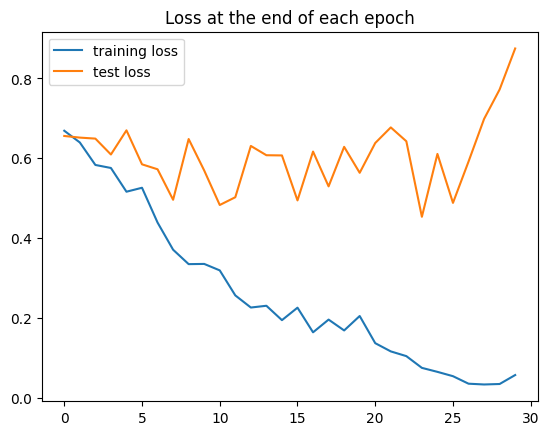

In [ ]:
trainer = Trainer(criterion,optimizer)
trainer.fit(mymodel,trainloader,testloader,epochs = EPOCH)

In [ ]:
torch.save(mymodel.state_dict(),('/content/drive/MyDrive/Assignment_Pixxel/model_last.pt'))

## From Above Observations
###The model best accuracy is <b>83.8% </b> when the validation loss is minimum

## Inferencing and Evaluation Based on Trained model

In [18]:
PATH = '/content/drive/MyDrive/Assignment_Pixxel/models/model_best.pt'

# Load
infer_device = torch.device('cpu')
pred_model = ClassificationNet()
pred_model.load_state_dict(torch.load(PATH, map_location=infer_device))

<All keys matched successfully>

In [19]:
pred_model.eval()
y_pred_list = []
y_test = []
with torch.no_grad():
  for imgs1, imgs2, label in tqdm(testloader):

    #take data to device
    imgs1 = imgs1.to(device)
    imgs2 = imgs2.to(device)

    # compute output
    pred_tensor = pred_model(imgs1,imgs2)
    y_pred_tag = torch.round(pred_tensor)
    y_pred_list.append(y_pred_tag.cpu().detach().numpy())
    y_test.append(label)

y_pred_list = [a.squeeze().tolist() for a in y_pred_list]

  0%|          | 0/10 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
100%|██████████| 10/10 [08:52<00:00, 53.21s/it]


In [22]:
from sklearn.metrics import classification_report

In [42]:
y_total_test = []
for i in range(len(y_test)):
  y_total_test.append(y_test[i].cpu().detach().numpy())


In [43]:
y_total_test = np.concatenate(y_total_test)
y_total_pred = np.concatenate(np.array(y_pred_list))

In [44]:
print(classification_report(y_total_test, y_total_pred))

              precision    recall  f1-score   support

           0       0.84      0.84      0.84       160
           1       0.84      0.84      0.84       160

    accuracy                           0.84       320
   macro avg       0.84      0.84      0.84       320
weighted avg       0.84      0.84      0.84       320

